In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
#===================================================================================
#  PARAMETERS
#===================================================================================

az_res_scale = 1                            # values above 1 reduce resolution, but also computation time
fftsize = 4096*4                            # size of fft to use for backprojection range compression
# fftsize = 1702
N = (int)(np.ceil(fftsize/2))
c0 = 299702547                              # speed of light in the atmosphere (m/s)
actual_samples=1702                         # number of samples/chirp
PRF = 307.292                               # effective pulse repetition frequency (Hz)
azBW=0.1920                                 # 3dB antenna azimuth beamwidth (rad) (3dB to 3dB)
cabledelay = -1.2                           # system and cable delay (m)
f_adc = 24485000                            # adc sample rate (Hz)
bw = 170000000                              # transmit bandwidth (Hz)
fc = 5.42876e9                              # carrier frequency (Hz)
kr = 1.597249139246997e12                   # chirp rate
delrad = c0*f_adc/(4*kr*np.pi)              # meters per radian
delsamp = delrad*2*np.pi/actual_samples     # meters per real sample
delrsamp = delsamp*(actual_samples/fftsize) # meters per interpolated sample 
wavelength = c0/fc                          # carrier wave length
az_res = wavelength/(2*azBW)*az_res_scale   # azimuth resolution
rres = c0/(2*bw)                            # slant range resolution
a_end = 404.1059                            # ?
cable_delay = -1.2;

n_rows = 1702                               # number of range bins
n_cols = 3884                               # number of pulses

max_range = c0*f_adc/(4*kr)                 # maximum range without aliasing
z = 346.8229                                # mean altitude for all platform positions [m]

In [10]:
#===================================================================================
#  WINDOW FUNCTIONS
#===================================================================================

blackman_window = np.transpose(np.tile(np.blackman(n_rows), (n_cols, 1)))
hamming_window = np.transpose(np.tile(np.hamming(n_rows), (n_cols, 1)))

window_matrix = blackman_window

In [11]:
#===================================================================================
#  DATA
#===================================================================================

### Geometry
# geometry_data = np.fromfile('geometry_sim.bin', dtype='double')
geometry_data = np.fromfile('geometry_casie.bin', dtype='double')
geometry_data = geometry_data.reshape(4, n_cols)

t = (geometry_data[0]-geometry_data[0][0])/PRF # creating time axis t, lat, long, northing, easting
lat = geometry_data[1]
long = geometry_data[2]
ref_lat = np.mean(lat)                      # reference latitude
lat_cf = 1852.23 * 60.0                     # latitude conversion factor to convert lat to northing
long_cf = lat_cf*np.cos(ref_lat*np.pi/180)  # longitude conversion factor to convert longitude to easting
northing = lat*lat_cf
easting  = long*long_cf
z = geometry_data[3]-cabledelay             # altitude by cabledelay;

rot_angle = -np.arctan2((easting[len(easting)-1]-easting[0]),(northing[len(northing)-1]-northing[0]))+np.pi/2
c_angle = np.cos(rot_angle)
s_angle = np.sin(rot_angle)
l_northing = northing-northing[0]
l_easting = easting-easting[0]

# SAR Antenna Phase Center
r = c_angle*l_northing-s_angle*l_easting    # x[n]
a = s_angle*l_northing+c_angle*l_easting    # y[n]

### Phase History
uncompressed_data = np.fromfile('casie_data.bin', dtype='double')
uncompressed_data = uncompressed_data.reshape((n_rows, n_cols))

In [12]:
print(r)

[-0.00000000e+00  8.00145039e-04  1.60029009e-03 ...  1.95723800e-03
  9.78618216e-04 -8.52651283e-14]


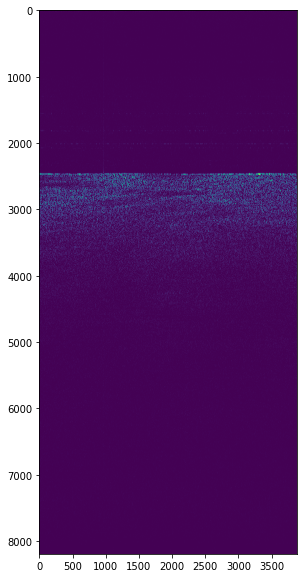

In [13]:
#===================================================================================
#  PRE-PROCESSING
#===================================================================================

### Range Compression
# Data is compressed by using a range window and zero-padding then performing an FFT.
windowed_data = np.multiply(uncompressed_data, window_matrix)

# Performing 1 dimensional FFT along rows. 
range_compressed = np.fft.fft(windowed_data, n=fftsize, axis=0)


# Discarding duplicated half of spectrum
fftsize = len(range_compressed) # the changed one
N = (int)(fftsize/2);
range_compressed = np.concatenate((range_compressed[0:N, :], np.zeros((1, n_cols))))

plt.figure(figsize=(20,10))
plt.imshow(abs(range_compressed))

In [14]:
#===================================================================================
# BACKPROJECTION IMAGE FORMATION ALGORITHM
#===================================================================================

### Grid Formation
ground_range = np.sqrt(np.power(max_range,2) - np.power(np.mean(z),2)) # max_range: hyp and z: opp

x = np.arange((rres + 30), (ground_range), rres, dtype='double')-(rres/2)
y = np.arange(az_res, a[len(a)-1], az_res, dtype='double') - (az_res/2)
# z = z*np.ones((1,n_cols))
z2 = np.power(z,2)

X, Y = np.meshgrid(x, y, indexing='xy')

# del x, y

# Constants in exponent
betapic=4*np.pi*kr/(c0**2)
lambda4pi=4*np.pi/wavelength;

# Defining output image and phase arrays
img = np.zeros((len(X), len(X[0])), dtype='complex128');
pphase = np.zeros((len(X), len(X[0])), dtype='complex128');

In [15]:
print(len(X))
print(len(X[0]))
print(betapic)
print(lambda4pi)

2810
1208
0.00022346095950526244
227.62505964424955


In [16]:
### Backprojection Loop
for n in range(0,1):
    # Computing (pulse index dependent) distance, d[n] between pixel (x0,y0,z0) and antenna phase center of SAR
    # antenna (x[n],y[n],z[n]) for a particular pulse number n.
    # Equation 5 in description of data and sofware document.
    tx = (X+r[n])
    tx2 = (np.power(tx,2))
    ty = (Y-a[n])
    ty2 = (np.power(ty,2))
    d2 = tx2+ty2+z2[n]
    d = np.sqrt(d2)
    
    # Estimating azimuth angle to each pixel
    mz = np.multiply(np.sqrt(tx2+(z[n]**2)),(np.sign(tx))) # can approximate by using mean(z) to lower computation
    az = np.arctan2(ty,mz)                    # azimuth angle to each pixel
    
    # Interpolation?
    temp = np.rint(np.divide(d,delrsamp)) # mapping the distances to samples in the range compressed data matrix.
    ids = temp.astype('int')
    
    ids[ids>N] = N # +1 # recall, when we discarded half of the fft result, we added an extra line of zeros so we can index right to the value of N instead of just before N
    pphase = np.exp(-1j*(betapic*d2-d*lambda4pi)) # calculate the expected phase

    # Multiplying and accumulating phase
    rc = (range_compressed[ids,n]).reshape((len(ids),len(ids[0])))
    az_ = (abs(az)<(azBW/2))
    az_exp = np.exp(- np.power(az,2)*30)
    
    img += np.multiply((np.multiply(pphase,rc)),(np.multiply(az_,az_exp)))
    
    print(n)

0


In [20]:
# print((np.multiply(pphase,rc)))
print(img)

# print(rc[851][0])
# print(img)
# # import scipy.io
# # scipy.io.savemat('test.mat', dict(img=img))
# # img.tofile('formed_img.dat')

[[-37793.53430928-3.28441945e+04j -34863.72728453+2.88361049e+04j
  -15020.68673144+4.26776218e+04j ...   -375.67318672+7.83546471e+01j
    -376.52671096-1.94468724e+01j   -272.82780619-2.35729269e+02j]
 [-37345.65472028-3.33518065e+04j -35249.947678  +2.83619402e+04j
  -15595.8790163 +4.24703078e+04j ...   -375.99056976+7.68154111e+01j
    -376.44362034-2.09875595e+01j   -271.8612961 -2.36842756e+02j]
 [-36429.52759103-3.43486187e+04j -36002.97418195+2.73981821e+04j
  -16737.57906909+4.20324641e+04j ...   -376.6064107 +7.37331086e+01j
    -376.25852797-2.40678448e+01j   -269.91465896-2.39057823e+02j]
 ...
 [     0.        +0.00000000e+00j      0.        +0.00000000e+00j
       0.        +0.00000000e+00j ...      0.        +0.00000000e+00j
       0.        +0.00000000e+00j      0.        +0.00000000e+00j]
 [     0.        +0.00000000e+00j      0.        +0.00000000e+00j
       0.        +0.00000000e+00j ...      0.        +0.00000000e+00j
       0.        +0.00000000e+00j      0.      

In [18]:
# img = np.fromfile('formed_img.dat', dtype='complex128')
img = img.reshape((len(X), len(X[0])))

In [19]:
# plt.figure(figsize=(10,10))
# plt.imshow(20*np.log10(abs(img)), aspect=0.3, cmap='gray')
# img -= np.max(img)
# # img = np.clip(img, -100, 0)